# 🏭 Simulación de una Fábrica usando SimPy

Este notebook describe y explica la simulación de una fábrica que utiliza diferentes máquinas para procesar piezas. La simulación está modelada usando SimPy, una librería para simular sistemas de eventos discretos. A continuación, se desglosará el código y la lógica en partes claras.

---


## ✨ Introducción a la Simulación

En este sistema, una fábrica tiene varias estaciones con máquinas que procesan diferentes tipos de piezas. Cada tipo de pieza tiene una ruta específica a través de las estaciones, y cada estación tiene un número determinado de máquinas. La simulación sigue la llegada de piezas y su procesamiento, y genera estadísticas sobre la utilización de las estaciones, los tiempos de espera y otros indicadores clave.

### Parámetros clave:

- `NUM_STATIONS`: Número de estaciones en la fábrica.
- `SIMULATION_TIME`: Tiempo de simulación en horas (365 días de trabajo de 8 horas).
- `MACHINES_PER_STATION`: Lista con el número de máquinas por estación.
- `SERVICE_TIMES`: Tiempos medios de servicio en horas para cada tipo de pieza en cada estación.
- `ROUTES`: Ruta específica que cada tipo de pieza debe seguir por las estaciones.
- `ARRIVAL_MEAN`: Tiempo medio de llegada de piezas.

---

In [21]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

In [22]:
NUM_STATIONS = 5
SIMULATION_TIME = 365 * 8

MACHINES_PER_STATION = [3, 2, 4, 3, 1]


SERVICE_TIMES = {
    1: [0.85, 0.5, 0.6, 0.5],
    2: [1.1, 0.8, 0.75],
    3: [1.2, 0.25, 0.7, 0.9, 1.0]
}

ROUTES = {
    1: [2, 0, 1, 4],
    2: [3, 0, 2],
    3: [1, 4, 0, 3, 2]
}

PIECE_PROBABILITIES = [0.3, 0.5, 0.2]

ARRIVAL_MEAN = 0.25

## 🔧 Clase Station

Esta clase modela una estación dentro de la fábrica. Cada estación tiene un número de máquinas que procesan las piezas y se lleva un registro del tiempo de espera y del tiempo en que las máquinas están ocupadas.


In [23]:
class Station:
    def __init__(self, env, num_machines, station_id):
        self.env = env
        self.station_id = station_id
        self.machines = simpy.Resource(env, num_machines)
        self.total_wait_time = 0
        self.total_busy_time = 0
        self.num_pieces = 0
        self.wait_times = []

    def process(self, piece_id, piece_type, service_time):
        with self.machines.request() as request:
            yield request
            # Simulate processing time
            process_time = np.random.exponential(service_time)
            self.total_busy_time += process_time  # Accumulate busy time
            yield self.env.timeout(process_time)
            self.num_pieces += 1

    def add_wait_time(self, wait_time):
        self.total_wait_time += wait_time
        self.wait_times.append(wait_time)

### 💡 Explicación
- Inicialización: La estación se inicializa con un número de máquinas (num_machines) y un identificador (station_id).
- process(): Simula el procesamiento de una pieza en la estación. Usa una distribución exponencial para el tiempo de servicio y acumula el tiempo en que las máquinas están ocupadas.
- add_wait_time(): Registra el tiempo que una pieza espera en la cola antes de ser procesada.

## 🧩 Clase Piece
La clase Piece modela las piezas que se crean en el sistema y siguen una ruta específica de procesamiento a través de diferentes estaciones.

In [24]:
# Create piece
class Piece:
    def __init__(self, env, id, type, system):
        self.env = env
        self.id = id
        self.type = type
        self.system = system
        self.start_time = env.now  # Arrival time
        self.wait_times = []
        self.processes_completed = 0
        self.action = env.process(self.process())

    def process(self):
        route = ROUTES[self.type]
        service_times = SERVICE_TIMES[self.type]
        for i, station_id in enumerate(route):
            station = self.system.stations[station_id]
            service_time = service_times[i]

            # Log arrival time and queue wait time
            wait_start_time = self.env.now
            yield self.env.process(station.process(self.id, self.type, service_time))
            wait_time = self.env.now - wait_start_time

            # Update wait time metrics
            station.add_wait_time(wait_time)
            self.wait_times.append(wait_time)
            self.processes_completed += 1

        # Calculate total cycle time
        cycle_time = self.env.now - self.start_time
        self.system.cycle_times.append(cycle_time)

## 🏭 Clase ManufacturingSystem
Esta clase modela todo el sistema de manufactura, controlando la generación de piezas y la gestión de las estaciones. También calcula las estadísticas finales una vez completada la simulación.

In [25]:
class ManufacturingSystem:
    def __init__(self, env):
        self.env = env
        self.stations = [Station(env, MACHINES_PER_STATION[i], i) for i in range(NUM_STATIONS)]
        self.num_pieces_created = 0
        self.cycle_times = []  # To log cycle time of each piece

    def generate_piece(self):
        while True:
            piece_type = np.random.choice([1, 2, 3], p=PIECE_PROBABILITIES)
            self.num_pieces_created += 1
            Piece(self.env, self.num_pieces_created, piece_type, self)
            # Time between arrivals
            yield self.env.timeout(np.random.exponential(ARRIVAL_MEAN))

    def run_simulation(self):
        # Start the piece generation process
        self.env.process(self.generate_piece())
        # Run the simulation for the defined time
        self.env.run(until=SIMULATION_TIME)
        # Calculate results
        self.calculate_statistics()

    def calculate_statistics(self):
        print(f"Simulation completed. Processed pieces: {self.num_pieces_created}")
        utilizations = []
        avg_wait_times = []
        avg_pieces_in_queue = []

        for i, station in enumerate(self.stations):
            utilization = station.total_busy_time / (SIMULATION_TIME * MACHINES_PER_STATION[i])
            utilizations.append(utilization)
            avg_wait_time = station.total_wait_time / station.num_pieces if station.num_pieces > 0 else 0
            avg_wait_times.append(avg_wait_time)
            avg_pieces_in_queue.append(len(station.wait_times) / SIMULATION_TIME)

            print(f"Station {i+1}:")
            print(f"  Utilization: {utilization}")
            print(f"  Average wait time: {avg_wait_time}")
            print(f"  Processed pieces: {station.num_pieces}")

        # Calculate arrival and departure rates
        arrival_rate = self.num_pieces_created / SIMULATION_TIME
        departure_rate = sum([station.num_pieces for station in self.stations]) / SIMULATION_TIME
        print(f"Arrival rate: {arrival_rate}")
        print(f"Departure rate: {departure_rate}")
        print(f"Average cycle time: {np.mean(self.cycle_times)}")

        print("\nFinal analysis completed.\n")

        # Plot metrics
        self.plot_metrics(utilizations, avg_wait_times, avg_pieces_in_queue)

    def plot_metrics(self, utilizations, avg_wait_times, avg_pieces_in_queue):
        stations = [f"Station {i+1}" for i in range(NUM_STATIONS)]

        # Create a figure with subplots
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))

        # Utilization plot
        axs[0, 0].bar(stations, utilizations, color='skyblue')
        axs[0, 0].set_title('Utilization of each station')
        axs[0, 0].set_xlabel('Stations')
        axs[0, 0].set_ylabel('Utilization')

        # Average wait time plot
        axs[0, 1].bar(stations, avg_wait_times, color='lightgreen')
        axs[0, 1].set_title('Average wait time per station')
        axs[0, 1].set_xlabel('Stations')
        axs[0, 1].set_ylabel('Average wait time (hours)')

        # Average pieces in queue plot
        axs[1, 0].bar(stations, avg_pieces_in_queue, color='salmon')
        axs[1, 0].set_title('Average number of pieces in queue per station')
        axs[1, 0].set_xlabel('Stations')
        axs[1, 0].set_ylabel('Average pieces in queue')

        # Cycle time distribution
        axs[1, 1].hist(self.cycle_times, bins=20, color='orchid')
        axs[1, 1].set_title('Cycle time distribution')
        axs[1, 1].set_xlabel('Cycle time (hours)')
        axs[1, 1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

### 💡 Explicación
- Inicialización: El sistema crea las estaciones basándose en el número de máquinas por estación.
generate_piece(): Genera piezas de manera continua, asignando a cada pieza un tipo y siguiendo su proceso.
- run_simulation(): Corre la simulación durante el tiempo total definido, y luego calcula estadísticas como la utilización de estaciones, tiempos de espera y tiempos de ciclo.
- plot_metrics(): Genera gráficos que muestran las métricas clave: utilización de estaciones, tiempo medio de espera, número de piezas en cola, y distribución de los tiempos de ciclo.

## 📈 Ejecución de la Simulación


Simulation completed. Processed pieces: 11830
Station 1:
  Utilization: 0.9112098964538884
  Average wait time: 2.548292824671445
  Processed pieces: 11804
Station 2:
  Utilization: 0.8536053063265865
  Average wait time: 3.908109308285511
  Processed pieces: 5957
Station 3:
  Utilization: 0.8441668117130512
  Average wait time: 1.8721808990773958
  Processed pieces: 11807
Station 4:
  Utilization: 0.9689895210907788
  Average wait time: 9.97464310048667
  Processed pieces: 8176
Station 5:
  Utilization: 0.807259794886686
  Average wait time: 2.3828447570874656
  Processed pieces: 5956
Arrival rate: 4.051369863013699
Departure rate: 14.965753424657533
Average cycle time: 14.507927120823505

Final analysis completed.



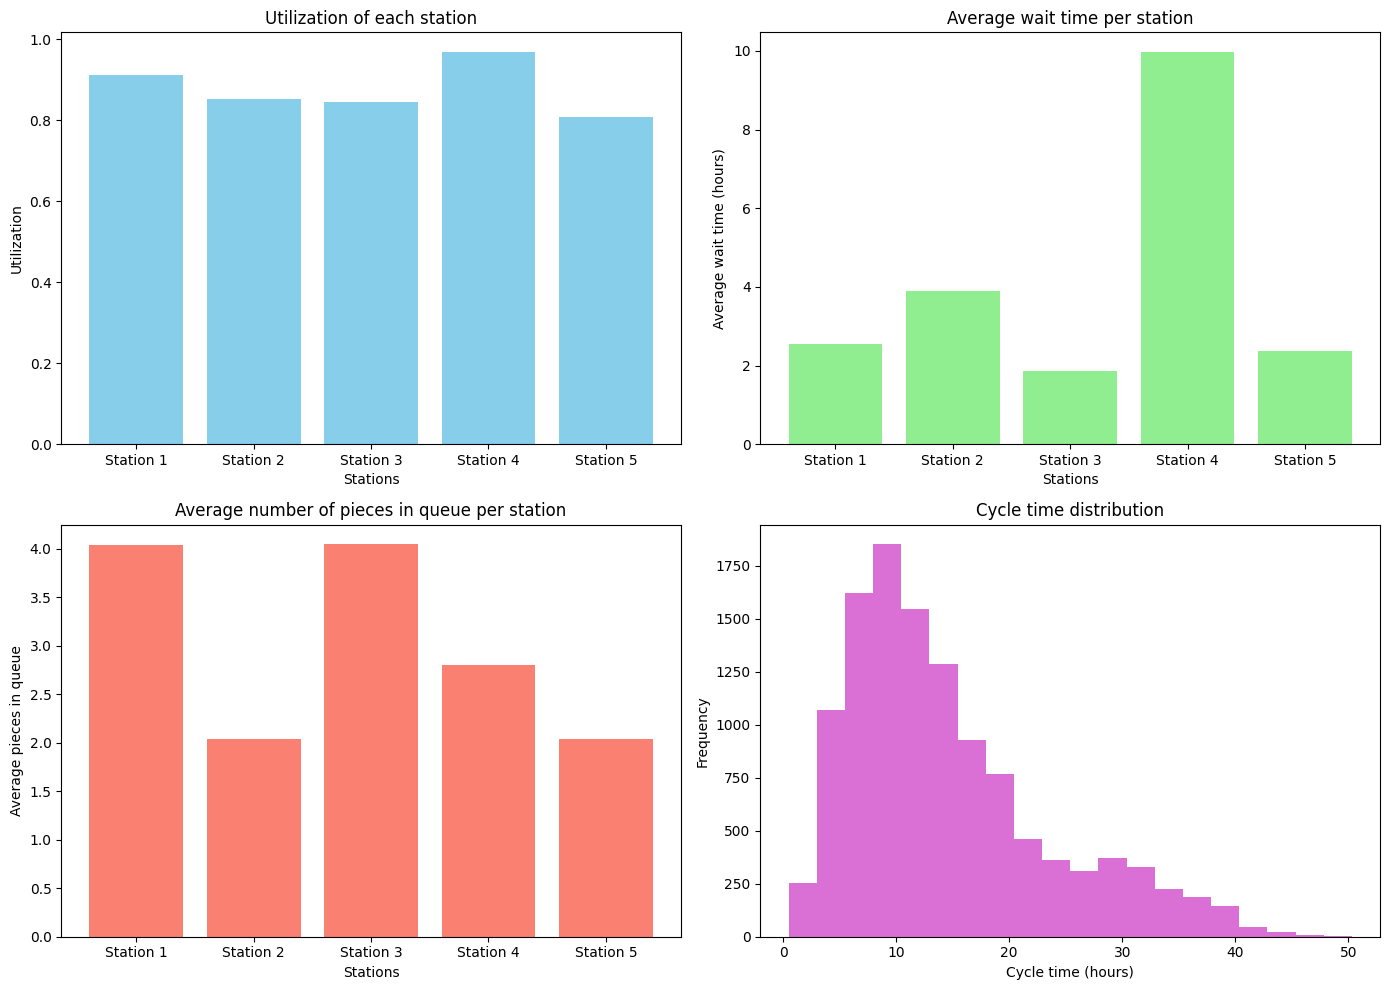

In [26]:
env = simpy.Environment()
system = ManufacturingSystem(env)
system.run_simulation()

## Análisis de los Gráficos 📊

A continuacion se detalla cada uno de los graficos y que informacion puede obtenerse de cada uno.

---

### **Gráfico 1: Utilización de cada estación** ⚙️📊

Este gráfico muestra la **utilización** de las cinco estaciones de la fábrica. La utilización se refiere a la proporción del tiempo que las máquinas en cada estación estuvieron ocupadas procesando piezas, en comparación con el tiempo total de simulación.

- **📈 Estaciones con mayor utilización**: La **Estación 4** tiene la mayor utilización, cercana al 1. Esto significa que sus máquinas estuvieron casi al 100% de capacidad, lo que sugiere un posible **cuello de botella** en el sistema.
- **📉 Estaciones con menor utilización**: La **Estación 2** y la **Estación 5** muestran una menor utilización, lo que indica que sus máquinas estuvieron ociosas por más tiempo en comparación con otras estaciones.
  
**Conclusión**: Se podría investigar por qué la Estación 4 está tan cargada y evaluar si es necesario añadir más máquinas en esa estación o ajustar la distribución de piezas para reducir la sobrecarga.

---

### **Gráfico 2: Tiempo de espera promedio por estación** ⏳🚶

Este gráfico muestra el **tiempo de espera promedio** que las piezas pasan en cola antes de ser procesadas en cada estación.

- **⏱️ Mayor tiempo de espera**: La **Estación 4** nuevamente destaca, con un tiempo de espera promedio muy superior al de las demás estaciones (más de 7 horas). Esto refuerza la idea de que esta estación es un cuello de botella.
- **⌛ Menor tiempo de espera**: La **Estación 3** y la **Estación 5** tienen tiempos de espera bajos, lo que significa que las piezas no pasan mucho tiempo esperando ser procesadas en estas estaciones.

**Conclusión**: El largo tiempo de espera en la Estación 4 confirma que esta estación tiene problemas de capacidad, lo que está retrasando el flujo general de piezas. Podría ser necesario agregar más recursos o mejorar la eficiencia en esa estación.

---

### **Gráfico 3: Promedio de piezas en cola por estación** 🛠️📦

Este gráfico muestra el **promedio de piezas en cola** en cada estación a lo largo del tiempo de simulación.

- **🏗️ Estaciones con más piezas en cola**: La **Estación 1** y la **Estación 3** tienen, en promedio, más de 3 piezas esperando en cola. Aunque no tengan los mayores tiempos de espera, parece que la cantidad de piezas que llegan a estas estaciones es alta, lo que sugiere una alta carga de trabajo.
- **📉 Estación con menos piezas en cola**: La **Estación 5** es la que menos piezas acumula en su cola, lo que indica que no está siendo muy demandada o tiene suficiente capacidad para atender las piezas de manera eficiente.

**Conclusión**: Se observa una gran acumulación de piezas en las Estaciones 1 y 3. Sin embargo, como sus tiempos de espera no son excesivos, esto sugiere que la capacidad de procesamiento de estas estaciones es suficiente, pero la demanda de piezas que pasan por estas estaciones es alta.

---

### **Gráfico 4: Distribución de tiempos de ciclo** 🕒📉

Este gráfico muestra la **distribución de los tiempos de ciclo**, que se refiere al tiempo total que una pieza tarda en pasar por todas las estaciones desde su llegada hasta que es procesada completamente.

- **📊 Forma de la distribución**: La distribución tiene una forma **asimétrica** con una concentración de piezas cuyo tiempo de ciclo está entre **10 y 20 horas**. La cola hacia la derecha indica que algunas piezas tardaron mucho más tiempo en completar su ciclo (más de 30 horas en algunos casos).
  
**Conclusión**: La mayoría de las piezas completan su ciclo en un tiempo razonable, pero hay algunas excepciones con tiempos de ciclo mucho más largos, posiblemente debido a retrasos en estaciones con alta carga, como la Estación 4. Esto sugiere que optimizar esa estación podría mejorar el tiempo de ciclo para la mayoría de las piezas.

---

### **Resumen de insights claves** 🧠✨
- La **Estación 4** es claramente un **cuello de botella** 🚧, con alta utilización y largos tiempos de espera.
- Las **Estaciones 1 y 3** también tienen bastante carga ⚖️, aunque no parece que sean críticas en términos de retrasos.
- Optimizar la **capacidad** o **eficiencia** en la **Estación 4** podría mejorar considerablemente el flujo de piezas y reducir los tiempos de ciclo en general 🔧⏱️.

---

Vemos que si agregamos una maquina adicional a la estacion 4, podemos notar como el rendimiento se establece en la media marcada por las demas estaciones, lo que nos indica que la estacion 4 es el cuello de botella de la fabrica.

Simulation completed. Processed pieces: 11601
Station 1:
  Utilization: 0.9166548685299095
  Average wait time: 2.8452773024954476
  Processed pieces: 11597
Station 2:
  Utilization: 0.8356691346708222
  Average wait time: 2.7292946042354886
  Processed pieces: 5783
Station 3:
  Utilization: 0.8291236926695594
  Average wait time: 1.553970140244805
  Processed pieces: 11596
Station 4:
  Utilization: 0.7131047694621334
  Average wait time: 1.4808981084837478
  Processed pieces: 8088
Station 5:
  Utilization: 0.7818750707508288
  Average wait time: 2.1271885685746903
  Processed pieces: 5783
Arrival rate: 3.972945205479452
Departure rate: 14.6736301369863
Average cycle time: 7.85437646759999

Final analysis completed.



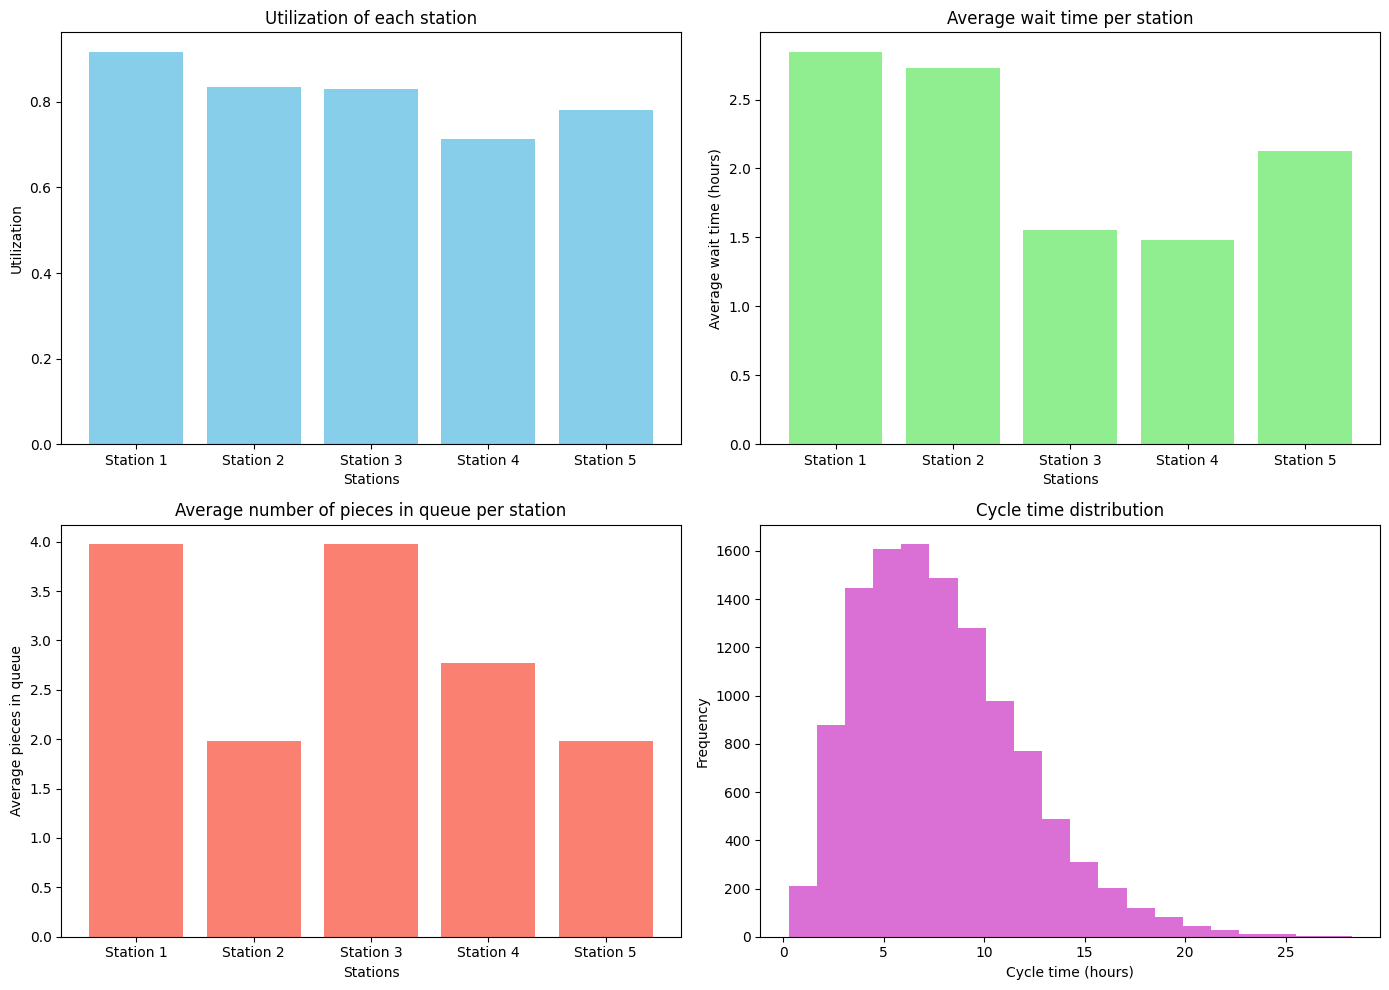

In [28]:
MACHINES_PER_STATION = [3, 2, 4, 4, 1] # Agregamos una maquina mas a la estacion 4, de 3 -> 4

# Run the simulation
env = simpy.Environment()
system = ManufacturingSystem(env)
system.run_simulation()